In [1]:
from importlib.metadata import version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dice_ml

from dice_ml import Dice
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
plt.style.use('dark_background')

In [3]:
# Print package versions
packages = ['dice_ml', 'scikit-learn', 'pandas', 
            'numpy', 'matplotlib', 'seaborn']
for package in packages:
    print(f"{package} version: {version(package)}")

dice_ml version: 0.11
scikit-learn version: 1.6.1
pandas version: 1.5.3
numpy version: 1.26.4
matplotlib version: 3.10.0
seaborn version: 0.13.2


In [4]:
# Load and prepare data
X, y = load_wine(as_frame=True, return_X_y=True) 
X = X.loc[:, ['alcohol', 'flavanoids', 'magnesium', 'proline']]
X.columns = X.columns.str.capitalize()

| **Aspect**           | **Model Counterfactuals**                            | **Actual Counterfactuals**                          |
|-----------------------|-----------------------------------------------------|----------------------------------------------------|
| **Context**           | Within the bounds of a trained model.               | Concerned with the real world.                    |
| **Objective**         | Explain or evaluate a model’s predictions.          | Understand true causal relationships or alternate realities. |
| **Dependency**        | Depends on the model’s structure and assumptions.   | Requires a causal mechanism or data about the real world. |
| **Use in AI/ML**      | Explainability, fairness, debugging, feature importance. | Causal inference, policy evaluation, treatment effects. |
| **Example Question**  | "What if the input value of age were higher in the model?" | "What if the individual had gone to college?"     |

In [6]:
# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

model_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', DecisionTreeClassifier())
])

# Train model
model_pipeline.fit(X_train, y_train)

# Model performance visualization
y_pred = model_pipeline.predict(X_test)

In [7]:
cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.73      0.79      0.76        14
           2       0.88      0.70      0.78        10

    accuracy                           0.81        36
   macro avg       0.82      0.80      0.81        36
weighted avg       0.81      0.81      0.80        36



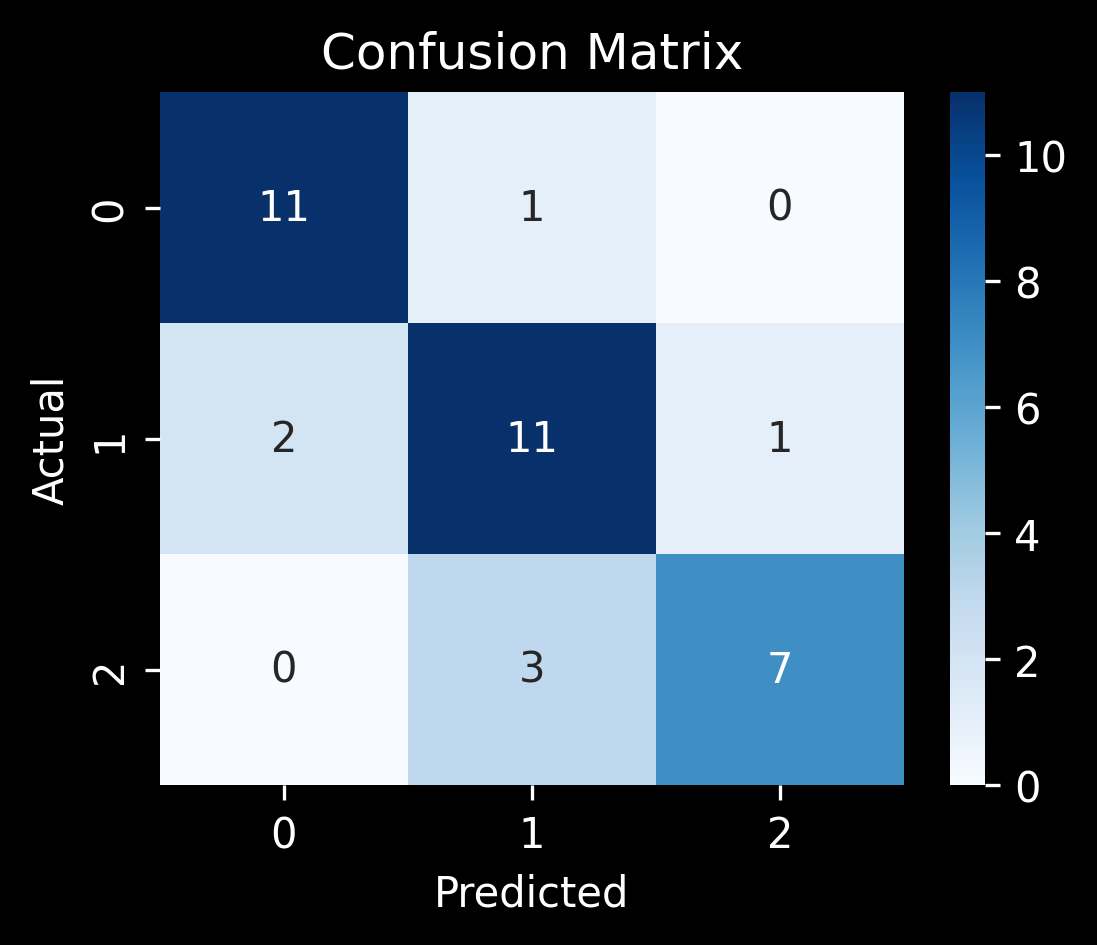

In [8]:
plt.figure(figsize=(4, 3), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# DiCE Counterfactual Analysis
D = dice_ml.Data(
    dataframe=pd.concat([X, y], axis=1),
    continuous_features=X.columns.to_list(),
    outcome_name='target'
)

M = dice_ml.Model(
    model=model_pipeline,
    backend='sklearn',
    model_type='classifier'
)

C = Dice(D, M, method='genetic')

# Generate counterfactuals for a specific instance
instance = X_test[4: 5]
y_pred_instance = model_pipeline.predict(instance)
print("\nSelected Instance Prediction:", y_pred_instance)

counterfactuals = C.generate_counterfactuals(
    instance, total_CFs=4, desired_class=2
)

# Visualize counterfactuals
cf_df = counterfactuals.visualize_as_dataframe(show_only_changes=True)


Selected Instance Prediction: [1]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.93it/s]

Query instance (original outcome : 1)


,Alcohol,Flavanoids,Magnesium,Proline,target
0,13.03,2.03,86.0,392.0,1



Diverse Counterfactual set (new outcome: 2)


,Alcohol,Flavanoids,Magnesium,Proline,target
0,12.87,0.65,-,625.0,2.0
0,12.77,0.51,-,470.0,2.0
0,13.08,1.39,113.0,550.0,2.0
0,13.11,1.28,116.0,425.0,2.0


<h1 style="font-weight: bold; background: linear-gradient(to right, teal, black); -webkit-background-clip: text; color: transparent;"> Model Counterfactuals vs. Actual Counterfactuals
</h1>

<h2 style="font-weight: bold; background: linear-gradient(to right, magenta, cyan); -webkit-background-clip: text; color: transparent;"> 1. Model Counterfactuals
</h2>

### Definition
Hypothetical scenarios generated within the constraints of a trained model to explore alternative outcomes based on input changes.

### Objective
To understand the model’s behavior and decision boundaries by asking:

> What if $ X $ changes to $ X' $, how does $ Y $ (the output) change?

### Example
Given a model $ f(X) $, we want to find the smallest perturbation $\Delta X$ such that:

$
f(X + \Delta X) = Y^*
$

where $ Y^* $ is the desired outcome or class.

---

<h2 style="font-weight: bold; background: linear-gradient(to right, magenta, cyan); -webkit-background-clip: text; color: transparent;"> 2. Actual Counterfactuals
</h2>

### Framework
- Causal inference techniques (e.g., Structural Causal Models, Potential Outcomes Framework).
- Assumes a causal mechanism \( g(X) \) that relates inputs to real-world outcomes \( Y \).

### Key Property
Actual counterfactuals of real-world events inherently deal with hypothetical alternate scenarios, which cannot be directly observed or verified because only the factual scenario is observable in our universe. Example:

_*We cannot observe the same individual in two alternate realities simultaneously (e.g., as different genders).
However, we can estimate or approximate potential outcomes by leveraging data about group-level effects (e.g., statistical or causal inferences drawn from populations).*_

_*This ties into the core limitation of actual counterfactuals: they require assumptions and models (such as causal inference frameworks) to bridge the gap between the observed and unobserved scenarios. These assumptions influence the accuracy and reliability of the estimations.*_


### Applications
- Policy evaluation (e.g., the effect of a treatment).
- Understanding cause-effect relationships.


<h2 style="font-weight: bold; background: linear-gradient(to right, magenta, cyan); -webkit-background-clip: text; color: transparent;"> 3. DiCE Counterfactuals
</h2>

### Definition
Diverse Counterfactual Explanations (DiCE) focus on generating actionable, feasible, and diverse model counterfactuals.

### Objective
To find minimal changes $ \Delta X $ in the input $ X $ such that the model’s prediction $ f(X + \Delta X) $ meets a desired condition:

$$
\text{Find } \Delta X \\
\text{ minimizing } \| \Delta X \|_p \\
\text{ subject to } f(X + \Delta X) = Y^*.
$$

### Assumptions
- The model $ f $ has learned a functional relationship approximating the true mapping between inputs and outputs.
- Counterfactuals are not causal but operate within the model’s learned domain.

### Features
- **Specifying which inputs to change**: Users can define which features are allowed to be altered.
- **Difficulty of changing inputs**: DiCE allows assigning costs or difficulty levels to changing specific features.
- **Specifying constraints**: Constraints such as bounds on feature values or interdependencies can be imposed to ensure realistic counterfactuals.
